## Household Power Consumption Forecasting
## (Supplementary Notebook)

General Note: For uniformity and reusability, most of the following Notes and Codes were copied from the previous module on Temperature Forecasting (Supplementary Notebook) and were modified only as needed.
<br>
<br>
The Household Power Consumption Dataset can be downloaded from Kaggle website through the following URL link:
<br>
https://www.kaggle.com/datasets/uciml/electric-power-consumption-data-set?select=household_power_consumption.txt

This supplementary notebook applies the methodology used in the M5 Forecasting notebook to the Household Power Consumption dataset. In tis supplementary notebook, we will be forecasting the household daily power consumption.
<br>
<br>
This supplementary notebook was prepared by Leo R. De Velez

### 1. Load the Household Power Consumption (Daily) Dataset

Load the previously downloaded Household Power Consumption dataset.

In [1]:
##
## The following codes were copied from Temperature Forecasting (Supplementary Notebook)
## and modified only as needed.
##

import numpy as np
import pandas as pd
from pandas import DataFrame
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

### CREATE X,Y ####
def create_xy(series, window_size, prediction_horizon, shuffle = False):
    x = []
    y = []
    for i in range(0, len(series)):
        if len(series[(i + window_size):(i + window_size + prediction_horizon)]) < prediction_horizon:
            break
        x.append(series[i:(i + window_size)])
        y.append(series[(i + window_size):(i + window_size + prediction_horizon)])
    x = np.array(x)
    y = np.array(y)
    return x,y

plt.rcParams['figure.figsize'] = [15, 5]

np.set_printoptions(precision = 6, suppress = True)

In [2]:
##
## This is an abbreviated version of Marwell Dalangin's data processing code
## and were modified only as needed.
##
## Download the data from
## https://www.kaggle.com/datasets/uciml/electric-power-consumption-data-set?select=household_power_consumption.txt
##

data_source = 'data/household_power_consumption.txt.zip'
df = pd.read_csv(data_source,
     sep=';',
     parse_dates={'dt': ['Date', 'Time']},
     infer_datetime_format=True,
     low_memory=False,
     na_values=['nan', '?'],
     index_col='dt')
df.columns = [x.lower() for x in df.columns]
# features
relevant_columns = [
    "global_active_power", "global_reactive_power", "voltage",
    "global_intensity", "sub_metering_1", "sub_metering_2",
    "sub_metering_3"
    ]
# Handling missing values
for every_column in relevant_columns:
    df[every_column] = df[every_column].interpolate()
# Computation for overall power consumtion
eq1 = (df['global_active_power'] * 1000 / 60)
eq2 = df['sub_metering_1'] + \
    df['sub_metering_2'] + df['sub_metering_3']
df['power_consumption'] = eq1 - eq2
relevant_columns = df.columns
# Aggregating level: "M" - Monthly, "W" - Weekly, "D" - Daily, "H" - Hourly
df = df[relevant_columns].resample("D").sum()
df = df['power_consumption']

### 2. Examine the Dataset

<bound method NDFrame.head of             power_consumption
dt                           
2006-12-16       14680.933333
2006-12-17       36946.666667
2006-12-18       19028.433333
2006-12-19       13131.900000
2006-12-20       20384.800000
...                       ...
2010-11-22       16924.600000
2010-11-23       16352.266667
2010-11-24       13769.466667
2010-11-25       17278.733333
2010-11-26       13347.733333

[1442 rows x 1 columns]>
DatetimeIndex(['2006-12-16', '2006-12-17', '2006-12-18', '2006-12-19',
               '2006-12-20', '2006-12-21', '2006-12-22', '2006-12-23',
               '2006-12-24', '2006-12-25',
               ...
               '2010-11-17', '2010-11-18', '2010-11-19', '2010-11-20',
               '2010-11-21', '2010-11-22', '2010-11-23', '2010-11-24',
               '2010-11-25', '2010-11-26'],
              dtype='datetime64[ns]', name='dt', length=1442, freq='D')


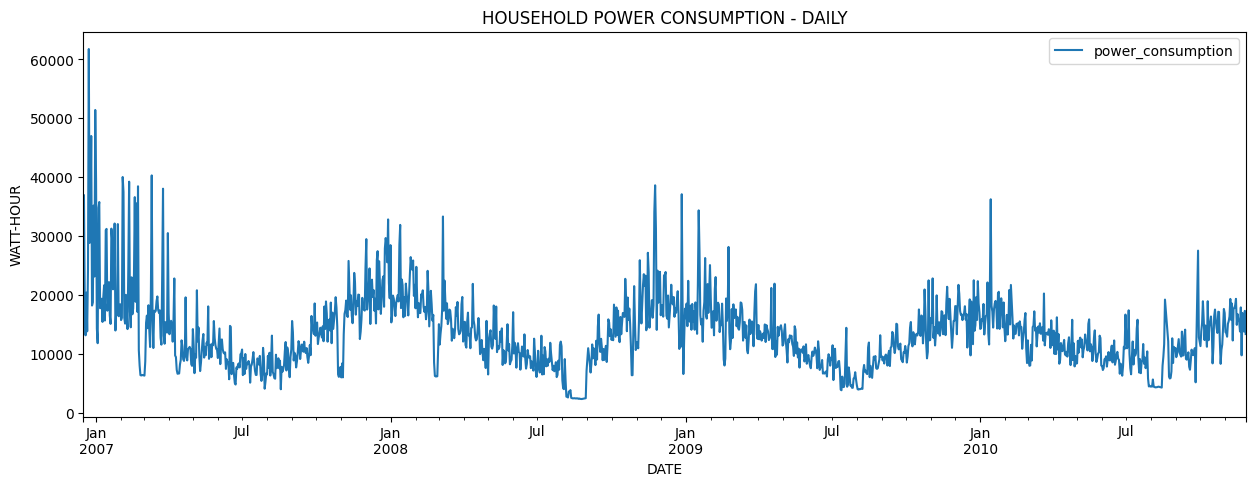

In [3]:
##
## The following codes were copied from Temperature Forecasting (Supplementary Notebook)
## and modified only as needed.
##

series = pd.DataFrame(df)
print(series.head)
print(series.index)

plt.rcParams['figure.figsize'] = [15, 5]
np.set_printoptions(precision = 6, suppress = True)
series.plot()
plt.title("HOUSEHOLD POWER CONSUMPTION - DAILY")
plt.xlabel("DATE")
plt.ylabel("WATT-HOUR")
plt.legend()
plt.show()

### 3. Prepare the Training, Validation, and Testing Data Sets

In [4]:
##
## The following codes were copied from Temperature Forecasting (Supplementary Notebook)
## and modified only as needed.
##

### HYPERPARAMETERS ###
window_size = 30
prediction_horizon = 1

test_split = 0.2
series_len = len(series)
test_len = int(series_len * test_split)
val_len = test_len
train_len = series_len - val_len - test_len

### TRAIN VAL SPLIT ###
train_series = series.iloc[:train_len, 0]
val_series = series.iloc[train_len:train_len+val_len, 0]
test_series = series.iloc[train_len+val_len:, 0]

train_x, train_y = create_xy(train_series.to_numpy(), window_size, prediction_horizon)
val_x, val_y = create_xy(val_series.to_numpy(), window_size, prediction_horizon)
test_x, test_y = create_xy(test_series.to_numpy(), window_size, prediction_horizon)

train_y = train_y.flatten()
val_y = val_y.flatten()
test_y = test_y.flatten()

print(train_x.shape)
print(train_y.shape)
print(val_x.shape)
print(val_y.shape)
print(test_x.shape)
print(test_y.shape)

(836, 30)
(836,)
(258, 30)
(258,)
(258, 30)
(258,)


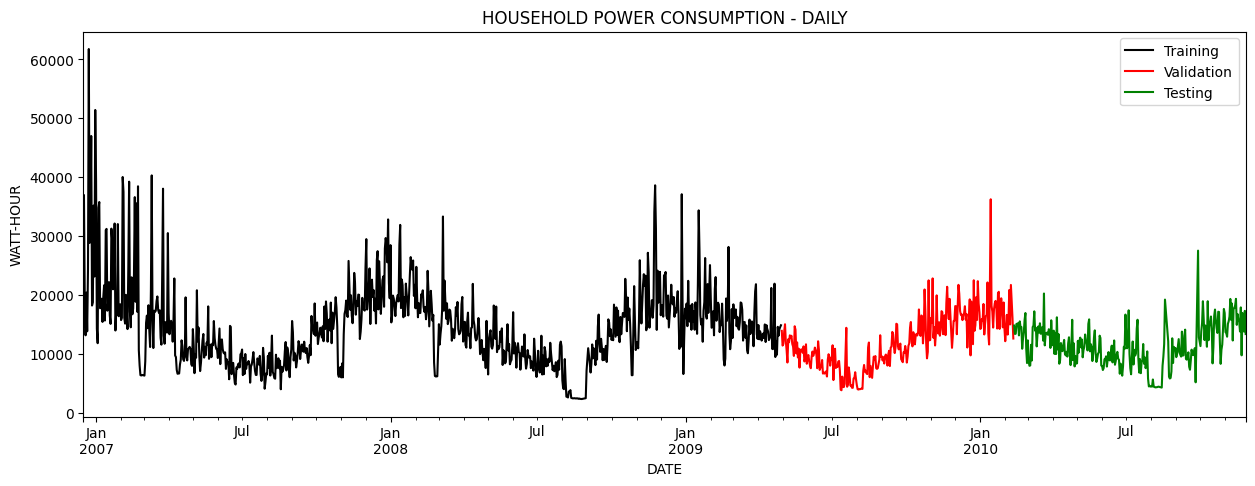

In [5]:
## Show the split of data from training, validation, and testing.

train_series.plot(color='black', label='Training')
val_series.plot(color='red', label = 'Validation')
test_series.plot(color='green', label = 'Testing')
plt.title("HOUSEHOLD POWER CONSUMPTION - DAILY")
plt.xlabel("DATE")
plt.ylabel("WATT-HOUR")
plt.legend()
plt.show()

### 4. Train the LightGBM Model and Evaluated with Validation Data

In [6]:
##
## The following codes were copied from Temperature Forecasting (Supplementary Notebook)
## and modified only as needed.
##

import lightgbm as lgb

model = lgb.LGBMRegressor()

model.fit(train_x, train_y,
          eval_metric = 'l1', 
          eval_set = [(val_x, val_y)],
          early_stopping_rounds = 100,
          verbose = 0)

LGBMRegressor()

### 5. Forecast and Compate with Test Data

In [7]:
## Check the forecasting accuracy of LightGBM

forecast = model.predict(test_x)
print('  LightGBM MAE  : %.4f' % (np.mean(np.abs(forecast - test_y))))
print('  LightGBM MAPE : %.4f' % (np.mean(np.abs(forecast - test_y)/test_y*100)))
print('  LightGBM RMSE : %.4f' % (np.sqrt(np.mean((forecast - test_y)**2))))

  LightGBM MAE  : 2096.1746
  LightGBM MAPE : 20.0793
  LightGBM RMSE : 2829.1513


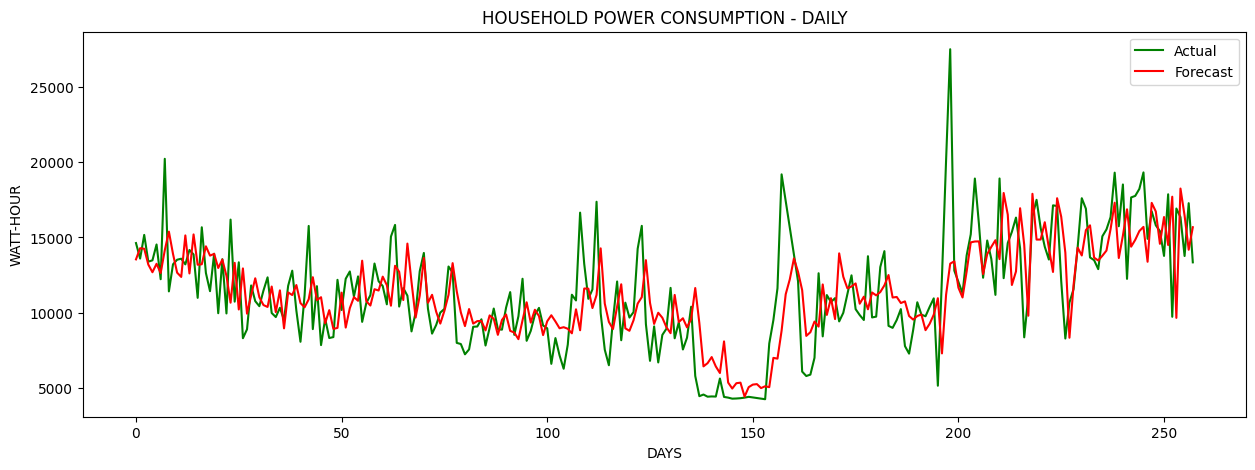

In [8]:
## Graphically compare the forecast vs actual data.
##

plt.plot(test_y, color='green', label = 'Actual')
plt.plot(forecast, color='red', label = 'Forecast')
plt.title("HOUSEHOLD POWER CONSUMPTION - DAILY")
plt.xlabel("DAYS")
plt.ylabel("WATT-HOUR")
plt.legend()
plt.show()

### 6. Compare Forecast Accuracy with Benchmarks

In [9]:
new_series = pd.DataFrame(test_series)
s1_naive = new_series[-29:-1].to_numpy()
s7_naive = new_series[-35:-7].to_numpy()
s30_naive = new_series[-56:-28].to_numpy()
#s365_naive = new_series[-364:-336].to_numpy()

print('     Naive MAE: %.4f' % (np.mean(np.abs(s1_naive - test_y))))
print('  s7-Naive MAE: %.4f' % (np.mean(np.abs(s7_naive - test_y))))
print(' s30-Naive MAE: %.4f' % (np.mean(np.abs(s30_naive - test_y))))
#print('s365-Naive MAE: %.4f' % (np.mean(np.abs(s365_naive - test_y))))
print('  LightGBM MAE: %.4f' % (np.mean(np.abs(forecast - test_y))))

print('     Naive MAPE: %.4f' % (np.mean(np.abs(s1_naive - test_y)/test_y*100)))
print('  s7-Naive MAPE: %.4f' % (np.mean(np.abs(s7_naive - test_y)/test_y*100)))
print(' s30-Naive MAPE: %.4f' % (np.mean(np.abs(s30_naive - test_y)/test_y*100)))
#print('s365-Naive MAPE: %.4f' % (np.mean(np.abs(s365_naive - test_y)/test_y*100)))
print('  LightGBM MAPE: %.4f' % (np.mean(np.abs(forecast - test_y)/test_y*100)))

     Naive MAE: 5241.3793
  s7-Naive MAE: 5026.2022
 s30-Naive MAE: 4398.0012
  LightGBM MAE: 2096.1746
     Naive MAPE: 62.9675
  s7-Naive MAPE: 59.7945
 s30-Naive MAPE: 51.7018
  LightGBM MAPE: 20.0793


### 7. Tune the LightGBM

Determine the best window setting for the LightGBM model.

  7 --- MAE: -3512.816 (377.905)
 14 --- MAE: -3230.065 (310.762)
 21 --- MAE: -3101.138 (385.383)
 30 --- MAE: -3078.382 (257.731)
 45 --- MAE: -2952.900 (340.629)
 90 --- MAE: -2624.300 (278.649)
180 --- MAE: -2588.767 (248.963)
365 --- MAE: -2657.241 (340.036)


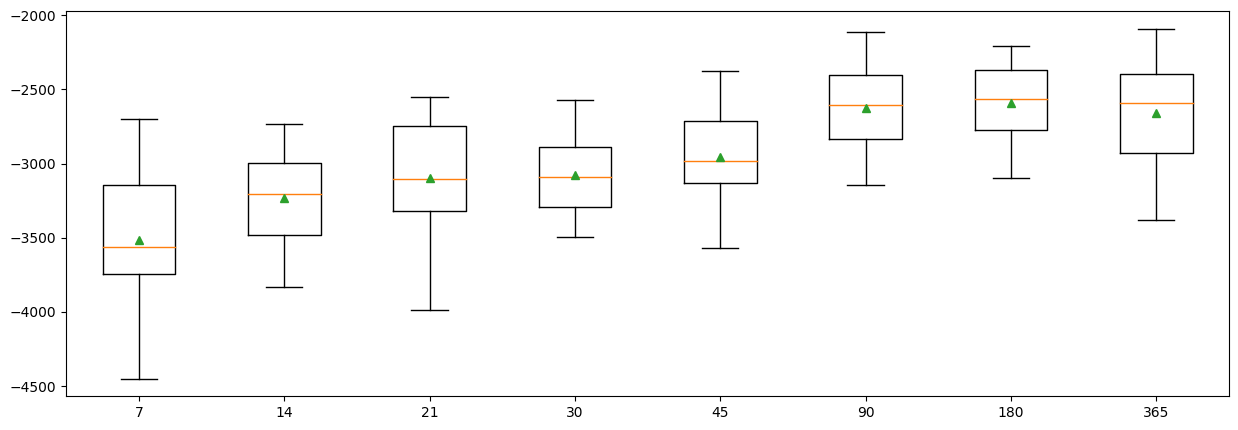

In [10]:
##
## The following codes were copied from this Time Series Workbook, Chapter 8, 
## lightgbm_m5_forecasting.ipynb
## and modified only as needed.
##

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold

params = {
    'n_estimators': 2000,
    'max_depth': 4,
    'num_leaves': 2**4,
    'learning_rate': 0.1,
    'boosting_type': 'dart'
}
windows = [7, 14, 21, 30, 45, 90, 180, 365]
results = []
names = []
for w in windows:
    window_size = w
    train_x, train_y = create_xy(train_series, window_size, prediction_horizon)
    train_y = train_y.flatten()
    cv = RepeatedKFold(n_splits = 10, n_repeats = 3, random_state = 123)
    scores = cross_val_score(lgb.LGBMRegressor(**params), train_x, train_y, scoring = 'neg_mean_absolute_error', cv = cv, n_jobs = -1)
    results.append(scores)
    names.append(w)
    print('%3d --- MAE: %.3f (%.3f)' % (w, np.mean(scores), np.std(scores)))

plt.rcParams['figure.figsize'] = [15, 5]    
plt.boxplot(results, labels = names, showmeans = True)
plt.show()

Use the window size that produced the lowest Mean Absolute Error. Compare the resulting MAE.

### 8. Adjust the Hyperparameters

In [11]:
##
## The following codes were copied from Temperature Forecasting (Supplementary Notebook)
## and modified only as needed.
##

### HYPERPARAMETERS ###
window_size = 180
prediction_horizon = 1

test_split = 0.2
series_len = len(series)
test_len = int(series_len * test_split)
val_len = test_len
train_len = series_len - val_len - test_len

### TRAIN VAL SPLIT ###
train_series = series.iloc[:train_len, 0]
val_series = series.iloc[train_len:train_len+val_len, 0]
test_series = series.iloc[train_len+val_len:, 0]

train_x, train_y = create_xy(train_series.to_numpy(), window_size, prediction_horizon)
val_x, val_y = create_xy(val_series.to_numpy(), window_size, prediction_horizon)
test_x, test_y = create_xy(test_series.to_numpy(), window_size, prediction_horizon)

train_y = train_y.flatten()
val_y = val_y.flatten()
test_y = test_y.flatten()

print(train_x.shape)
print(train_y.shape)
print(val_x.shape)
print(val_y.shape)
print(test_x.shape)
print(test_y.shape)

(686, 180)
(686,)
(108, 180)
(108,)
(108, 180)
(108,)


### 9. Retrain the LightGBM and Evaluate with Test Data

In [12]:
params = {
    'n_estimators': 2000,
    'max_depth': 4,
    'num_leaves': 2**4,
    'learning_rate': 0.01,
    'boosting_type': 'dart'
}

model = lgb.LGBMRegressor(first_metric_only = True, **params)

model.fit(train_x, train_y,
          eval_metric = 'l1', 
          eval_set = [(test_x, test_y)],
          #early_stopping_rounds = 10,
          verbose = 0)

LGBMRegressor(boosting_type='dart', first_metric_only=True, learning_rate=0.01,
              max_depth=4, n_estimators=2000, num_leaves=16)

### 10. Re-Forecast and Compare

In [13]:
## Re-Run the prediction model and check the resulting forecasting accuracy

forecast = model.predict(test_x)
print('  LightGBM MAE  : %.4f' % (np.mean(np.abs(forecast - test_y))))
print('  LightGBM MAPE : %.4f' % (np.mean(np.abs(forecast - test_y)/test_y*100)))
print('  LightGBM RMSE : %.4f' % (np.sqrt(np.mean((forecast - test_y)**2))))

  LightGBM MAE  : 2243.0828
  LightGBM MAPE : 18.5196
  LightGBM RMSE : 3200.8347


The LightRBM Mean Absolute Percent Error improved from about 20% down to about 18.5%.

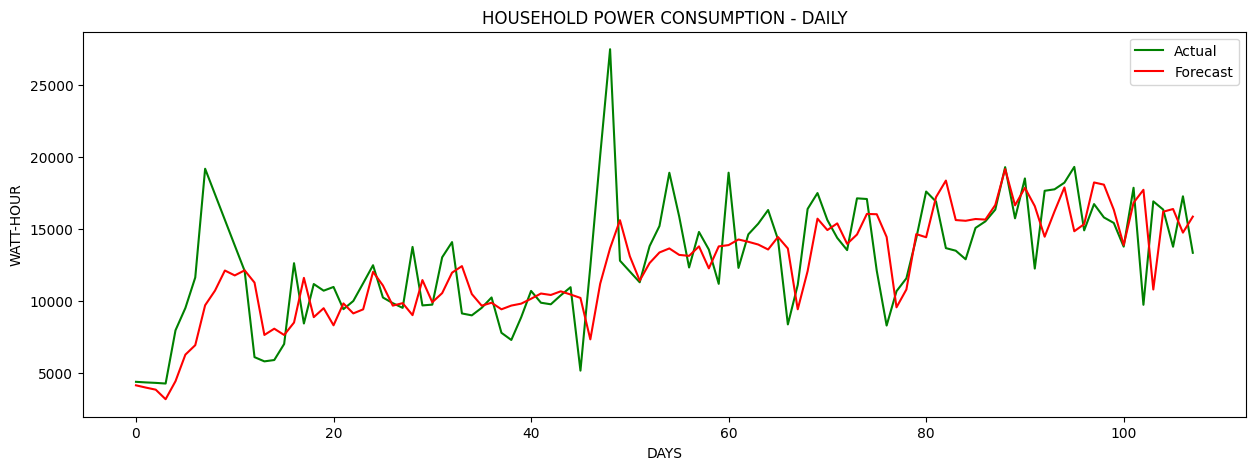

In [14]:
## Graphically compare the forecast vs actual data.

plt.plot(test_y, color='green', label = 'Actual')
plt.plot(forecast, color='red', label = 'Forecast')
plt.title("HOUSEHOLD POWER CONSUMPTION - DAILY")
plt.xlabel("DAYS")
plt.ylabel("WATT-HOUR")
plt.legend()
plt.show()

In [15]:
new_series = pd.DataFrame(test_series)
s1_naive = new_series[-29:-1].to_numpy()
s7_naive = new_series[-35:-7].to_numpy()
s30_naive = new_series[-56:-28].to_numpy()
#s365_naive = new_series[-364:-336].to_numpy()

print('     Naive MAE: %.4f' % (np.mean(np.abs(s1_naive - test_y))))
print('  s7-Naive MAE: %.4f' % (np.mean(np.abs(s7_naive - test_y))))
print(' s30-Naive MAE: %.4f' % (np.mean(np.abs(s30_naive - test_y))))
#print('s365-Naive MAE: %.4f' % (np.mean(np.abs(s365_naive - test_y))))
print('  LightGBM MAE: %.4f' % (np.mean(np.abs(forecast - test_y))))

print('     Naive MAPE: %.4f' % (np.mean(np.abs(s1_naive - test_y)/test_y*100)))
print('  s7-Naive MAPE: %.4f' % (np.mean(np.abs(s7_naive - test_y)/test_y*100)))
print(' s30-Naive MAPE: %.4f' % (np.mean(np.abs(s30_naive - test_y)/test_y*100)))
#print('s365-Naive MAPE: %.4f' % (np.mean(np.abs(s365_naive - test_y)/test_y*100)))
print('  LightGBM MAPE: %.4f' % (np.mean(np.abs(forecast - test_y)/test_y*100)))

     Naive MAE: 4427.2595
  s7-Naive MAE: 4371.9554
 s30-Naive MAE: 4050.7681
  LightGBM MAE: 2243.0828
     Naive MAPE: 48.4672
  s7-Naive MAPE: 46.8060
 s30-Naive MAPE: 41.7633
  LightGBM MAPE: 18.5196


### 11. Do Recursive LightGBM Forecasting

In [16]:
look_ahead = 30
recursive_x = test_x[0, -180:]

forecast_ms = []
#for i in range(test_x.shape[0]):
for i in range(look_ahead):
    pred = model.predict(recursive_x.reshape((1, recursive_x.shape[0])))
    recursive_x = np.append(recursive_x[1:], pred)
    forecast_ms.append(pred)
    
forecast_ms_rec = np.asarray(forecast_ms).flatten()
forecast_os = model.predict(test_x)

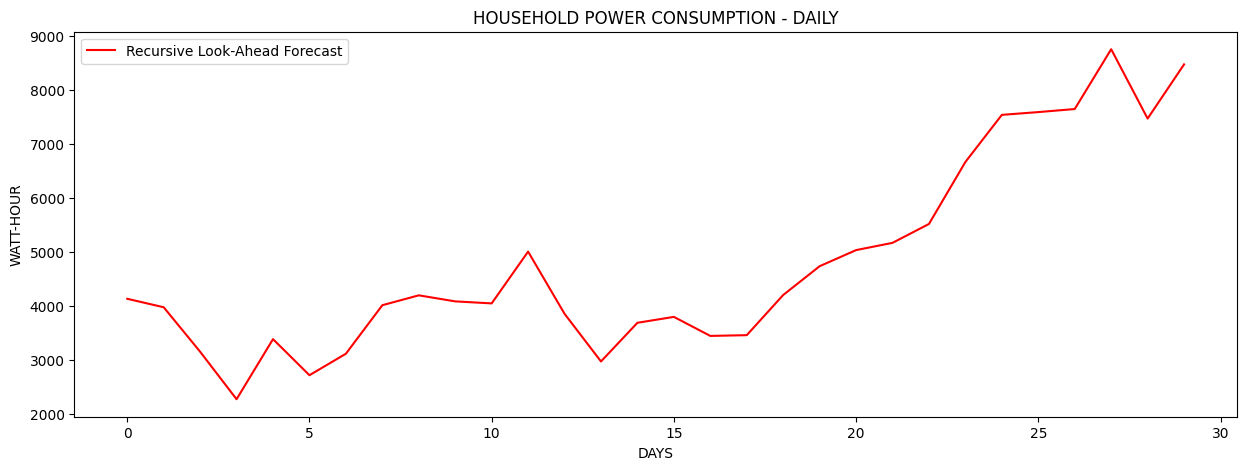

In [17]:
## Graphically compare the recursive forecast vs actual data.
##

#plt.plot(test_y, color='green', label = 'Actual')
plt.plot(forecast_ms, color='red', label = 'Recursive Look-Ahead Forecast')
plt.title("HOUSEHOLD POWER CONSUMPTION - DAILY")
plt.xlabel("DAYS")
plt.ylabel("WATT-HOUR")
plt.legend()
plt.show()

### 12. Summary

The forecasting accuracy of the LightGBM at around 18.5% Mean Absolute Percentage Error (MAPE) for the Daily Household Power Consumption was better than the MAPE Naive and sNaive benchmarks with MAPE above 40%.
<br><br>
The tuning of the LightGBM model improve its forecasting accuracy from around 20% MAPE down to around 18.5% MAPE.